# Pan01 Bottom Temperature in AABW formation regions

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe
import gsw

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [29]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35195/status,
Dashboard: /proxy/35195/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33633,Workers: 28
Dashboard: /proxy/35195/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:39411,Total threads: 1
Dashboard: /proxy/36865/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:46463,


In [4]:
# Importing data

pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month_z.nc'))
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/*/*.ocean_month_z.nc'))

In [5]:
## Creating shelf mask another way

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [6]:
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_01')

In [7]:
# Time variant variables
def preprocess(ds):
    ds = ds[['thetao','so']].where(shelf_mask == 1)
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [8]:
#Time slicing
cont = cont.sel(time=slice('2001-01-01','2010-12-31'))
melt = melt.sel(time=slice('2001-01-01','2010-12-31'))

In [9]:
#Time invariant variables
areaC = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])
areaM = xr.open_dataset('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/output020/20010101.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])

### Corrected area

In [10]:
# Variable for landmask
saltC = cont['so']
saltM = melt['so']

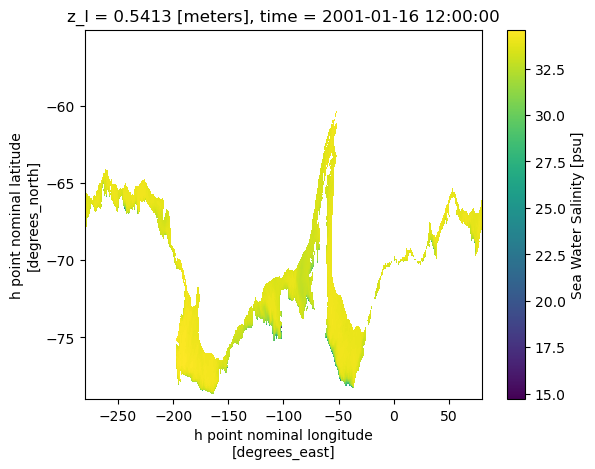

In [11]:
# Checking shelf mask
saltC.isel(z_l=0).isel(time=0).plot()

In [12]:
# Correcting area
areaC_corr = areaC*(saltC.isel(time=0,z_l=0)*0 +1)
areaM_corr = areaM*(saltM.isel(time=0,z_l=0)*0 +1)

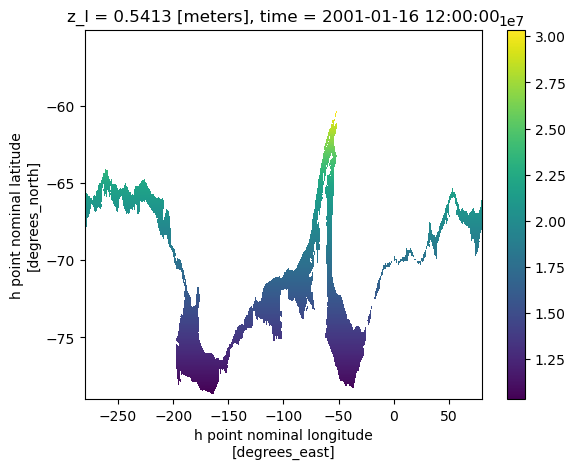

In [13]:
areaC_corr.plot()

In [14]:
## Weddell Sea
# Saved as _W
lat_slice_W = slice(-78,-71)
lon_slice_W = slice(-64.95,-44.95)

## Ross Sea
# Saved as _R
lat_slice_R = slice(-78,-71.5)
lon_slice_R = slice(-200,-175)

## Adelie Coast
# Saved as _A
lat_slice_A = slice(-69,-64.5)
lon_slice_A = slice(45,79)

## Prydz Bay
# Saved as _P
lat_slice_P = slice(-69,-65)
lon_slice_P = slice(-235,-205)

### Calculating temperature

In [15]:
# Calculating pressure
p_cont = gsw.p_from_z(-cont['z_l'], cont['yh'])
p_melt = gsw.p_from_z(-melt['z_l'], melt['yh'])

# Calculating absolute salinity
SA_cont = gsw.SA_from_SP(cont['so'], p_cont, cont['xh'], cont['yh'])
SA_melt =  gsw.SA_from_SP(melt['so'], p_melt, melt['xh'], melt['yh'])

# Calculating conservative temperature
tempC = gsw.CT_from_pt(SA_cont,cont['thetao'])
tempM = gsw.CT_from_pt(SA_melt,melt['thetao'])

In [16]:
# To fix the label issues
tempC = xr.DataArray(tempC, dims=cont['thetao'].dims, coords=cont['thetao'].coords)
tempC.attrs['units'] = '°C'
tempC.name = 'CT'

tempM = xr.DataArray(tempM, dims=melt['thetao'].dims, coords=melt['thetao'].coords)
tempM.attrs['units'] = '°C'
tempM.name = 'CT'

In [17]:
tempC = tempC.astype('float32')
tempM = tempM.astype('float32')
tempM

<xarray.DataArray 'CT' (time: 120, z_l: 75, yh: 533, xh: 3600)> Size: 69GB
dask.array<astype, shape=(120, 75, 533, 3600), dtype=float32, chunksize=(2, 22, 211, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 4kB -79.0 -78.95 -78.91 ... -55.18 -55.12 -55.07
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00
Attributes:
    units:          °C
    long_name:      Sea Water Salinity
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    cell_measures:  volume: volcello area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_salinity

### Bottom mask

In [18]:
bottom_mask_tempC = tempC.where(~np.isfinite(tempC.shift({'z_l': -1})))
bottom_mask_tempC = ~np.isnan(bottom_mask_tempC)

In [19]:
bottom_mask_tempM = tempM.where(~np.isfinite(tempM.shift({'z_l': -1})))
bottom_mask_tempM = ~np.isnan(bottom_mask_tempM)

In [20]:
bottemp_cont = tempC.where(bottom_mask_tempC).sum(dim='z_l')
bottemp_pert = tempM.where(bottom_mask_tempM).sum(dim='z_l')

### Time series

In [21]:
# Restricting to regions
bottemp_cont_W = bottemp_cont.sel(yh=lat_slice_W,xh=lon_slice_W)
bottemp_pert_W = bottemp_pert.sel(yh=lat_slice_W,xh=lon_slice_W)

bottemp_cont_R = bottemp_cont.sel(yh=lat_slice_R,xh=lon_slice_R)
bottemp_pert_R = bottemp_pert.sel(yh=lat_slice_R,xh=lon_slice_R)

bottemp_cont_A = bottemp_cont.sel(yh=lat_slice_A,xh=lon_slice_A)
bottemp_pert_A = bottemp_pert.sel(yh=lat_slice_A,xh=lon_slice_A)

bottemp_cont_P = bottemp_cont.sel(yh=lat_slice_P,xh=lon_slice_P)
bottemp_pert_P = bottemp_pert.sel(yh=lat_slice_P,xh=lon_slice_P)

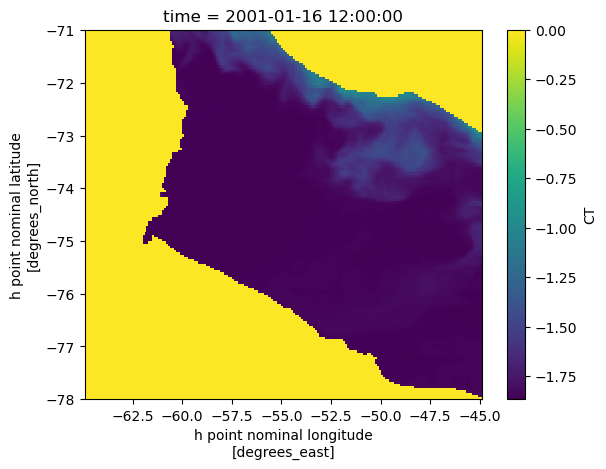

In [22]:
# Checking mask
bottemp_cont_W.isel(time=0).plot()

In [23]:
# Spatial averages
bottemp_cont_W_time = (areaC_corr * bottemp_cont_W).sum(['xh', 'yh']) / areaC_corr.sel(yh=lat_slice_W,xh=lon_slice_W).sum(['xh', 'yh'])
bottemp_pert_W_time = (areaM_corr * bottemp_pert_W).sum(['xh', 'yh']) / areaM_corr.sel(yh=lat_slice_W,xh=lon_slice_W).sum(['xh', 'yh'])

bottemp_cont_R_time = (areaC_corr * bottemp_cont_R).sum(['xh', 'yh']) / areaC_corr.sel(yh=lat_slice_R,xh=lon_slice_R).sum(['xh', 'yh'])
bottemp_pert_R_time = (areaM_corr * bottemp_pert_R).sum(['xh', 'yh']) / areaM_corr.sel(yh=lat_slice_R,xh=lon_slice_R).sum(['xh', 'yh'])

bottemp_cont_A_time = (areaC_corr * bottemp_cont_A).sum(['xh', 'yh']) / areaC_corr.sel(yh=lat_slice_A,xh=lon_slice_A).sum(['xh', 'yh'])
bottemp_pert_A_time = (areaM_corr * bottemp_pert_A).sum(['xh', 'yh']) / areaM_corr.sel(yh=lat_slice_A,xh=lon_slice_A).sum(['xh', 'yh'])

bottemp_cont_P_time = (areaC_corr * bottemp_cont_P).sum(['xh', 'yh']) / areaC_corr.sel(yh=lat_slice_P,xh=lon_slice_P).sum(['xh', 'yh'])
bottemp_pert_P_time = (areaM_corr * bottemp_pert_P).sum(['xh', 'yh']) / areaM_corr.sel(yh=lat_slice_P,xh=lon_slice_P).sum(['xh', 'yh'])

In [24]:
# Check shape
bottemp_cont_W_time

<xarray.DataArray (time: 120)> Size: 480B
dask.array<truediv, shape=(120,), dtype=float32, chunksize=(2,), chunktype=numpy.ndarray>
Coordinates:
    z_l      float64 8B 0.5413
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00

In [25]:
bottemp_cont_W_time = bottemp_cont_W_time.load()
bottemp_pert_W_time = bottemp_pert_W_time.load()

In [26]:
bottemp_cont_R_time = bottemp_cont_R_time.load()
bottemp_pert_R_time = bottemp_pert_R_time.load()

In [27]:
bottemp_cont_A_time = bottemp_cont_A_time.load()
bottemp_pert_A_time = bottemp_pert_A_time.load()

In [30]:
bottemp_cont_P_time = bottemp_cont_P_time.load()
bottemp_pert_P_time = bottemp_pert_P_time.load()

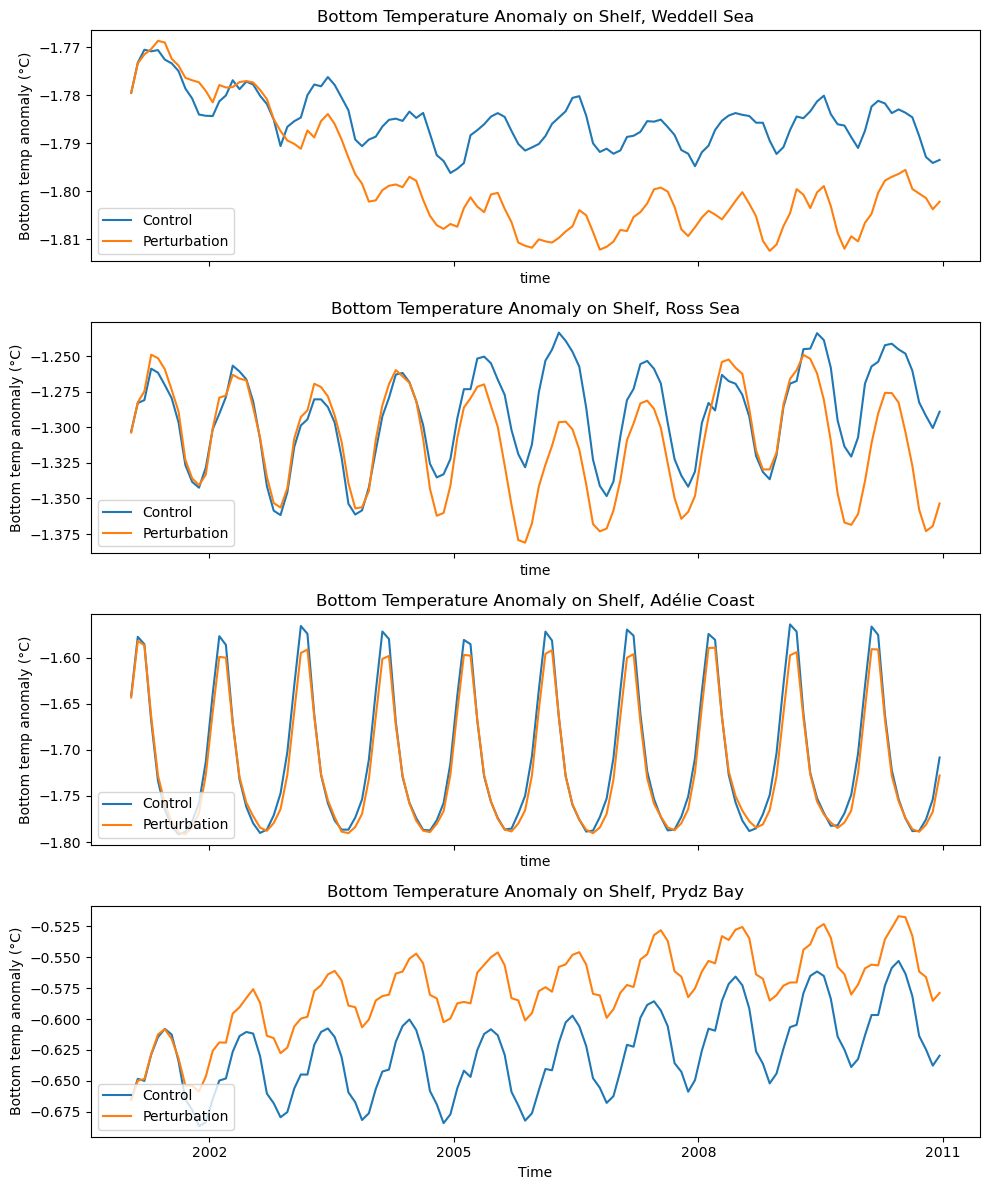

In [31]:
fig, axes = plt.subplots(
    nrows=4, ncols=1,
    sharex=True, figsize=(10, 12)
)

# First subplot: W_time
bottemp_cont_W_time.plot(ax=axes[0], label="Control")
bottemp_pert_W_time.plot(ax=axes[0], label="Perturbation")
axes[0].set_ylabel("Bottom temp anomaly (°C)")
axes[0].legend(loc="lower left")
axes[0].set_title("Bottom Temperature Anomaly on Shelf, Weddell Sea")

# Second subplot: R_time
bottemp_cont_R_time.plot(ax=axes[1], label="Control")
bottemp_pert_R_time.plot(ax=axes[1], label="Perturbation")
axes[1].set_ylabel("Bottom temp anomaly (°C)")
axes[1].legend(loc="lower left")
axes[1].set_title("Bottom Temperature Anomaly on Shelf, Ross Sea")

# Third subplot: A_time
bottemp_cont_A_time.plot(ax=axes[2], label="Control")
bottemp_pert_A_time.plot(ax=axes[2], label="Perturbation")
axes[2].set_ylabel("Bottom temp anomaly (°C)")
axes[2].legend(loc="lower left")
axes[2].set_title("Bottom Temperature Anomaly on Shelf, Adélie Coast")

# Fourth subplot: P_time
bottemp_cont_P_time.plot(ax=axes[3], label="Control")
bottemp_pert_P_time.plot(ax=axes[3], label="Perturbation")
axes[3].set_ylabel("Bottom temp anomaly (°C)")
axes[3].legend(loc="lower left")
axes[3].set_title("Bottom Temperature Anomaly on Shelf, Prydz Bay")

# Common X‑axis label
axes[-1].set_xlabel("Time")

# Adjust layout
plt.tight_layout()
plt.show()

In [32]:
bottemp_anom_W_time = bottemp_pert_W_time - bottemp_cont_W_time
bottemp_anom_W_time = bottemp_anom_W_time.load()
bottemp_anom_W_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_W_pan01.nc')

In [33]:
bottemp_anom_R_time = bottemp_pert_R_time - bottemp_cont_R_time
bottemp_anom_R_time = bottemp_anom_R_time.load()
bottemp_anom_R_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_R_pan01.nc')

In [34]:
bottemp_anom_A_time = bottemp_pert_A_time - bottemp_cont_A_time
bottemp_anom_A_time = bottemp_anom_A_time.load()
bottemp_anom_A_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_A_pan01.nc')

In [35]:
bottemp_anom_P_time = bottemp_pert_P_time - bottemp_cont_P_time
bottemp_anom_P_time = bottemp_anom_P_time.load()
bottemp_anom_P_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_P_pan01.nc')

#### All regions in one plot

Text(0.5, 1.0, 'Pan01 Time Series of Bottom Temperature on Shelf, AABW formation regions')

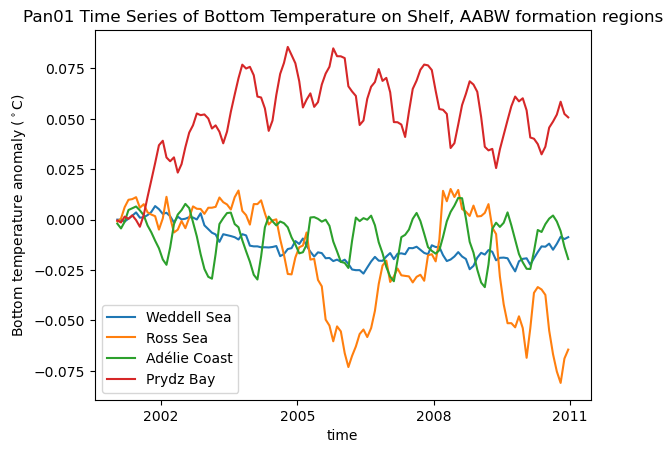

In [36]:
bottemp_anom_W_time.plot(label="Weddell Sea")
bottemp_anom_R_time.plot(label="Ross Sea")
bottemp_anom_A_time.plot(label="Adélie Coast")
bottemp_anom_P_time.plot(label="Prydz Bay")
plt.ylabel("Bottom temperature anomaly ($^\circ$C)")
plt.legend(loc="lower left")
plt.title("Pan01 Time Series of Bottom Temperature on Shelf, AABW formation regions")